In [11]:
import numpy as np 
import pandas as pd 
import seaborn as sns

import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.model_selection import GridSearchCV, KFold, train_test_split, TimeSeriesSplit
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.metrics import confusion_matrix, f1_score, mean_absolute_error, make_scorer
import lightgbm as lgb
import xgboost as xgb
import catboost as cb
import statsmodels.api as sm
from sklearn.metrics import make_scorer
from statsmodels.regression.linear_model import OLS
from datetime import datetime
from sklearn.model_selection import cross_val_score
from sklearn.cluster import DBSCAN
import shap
import matplotlib.pyplot as plt 

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/womenintheloop-data-science-hackathon/test_QkPvNLx.csv
/kaggle/input/womenintheloop-data-science-hackathon/train.csv
/kaggle/input/womenintheloop-data-science-hackathon/sample_submission_pn2DrMq.csv


In this kernel, I am going to show my classical approach to solve the time series problems on the example of Bain Woman HAckathon as well as econometric approach which I personally do not like due to its complexity and time taken to build a good model. I am not going to cover EDA part in details as it is not the main purpose of the kernel.

In [2]:
train = pd.read_csv('../input/womenintheloop-data-science-hackathon/train.csv')
test = pd.read_csv('../input/womenintheloop-data-science-hackathon/test_QkPvNLx.csv')
submission = pd.read_csv('../input/womenintheloop-data-science-hackathon/sample_submission_pn2DrMq.csv')

In [3]:
train.shape, test.shape, submission.shape

((512087, 11), (36000, 9), (36000, 2))

In [4]:
train.head()

,ID,Day_No,Course_ID,Course_Domain,Course_Type,Short_Promotion,Public_Holiday,Long_Promotion,User_Traffic,Competition_Metric,Sales
0,1,1,1,Development,Course,0,1,1,11004,0.007,81
1,2,2,1,Development,Course,0,0,1,13650,0.007,79
2,3,3,1,Development,Course,0,0,1,11655,0.007,75
3,4,4,1,Development,Course,0,0,1,12054,0.007,80
4,5,5,1,Development,Course,0,0,1,6804,0.007,41


In [5]:
train['Competition_Metric'] = train['Competition_Metric'].fillna(train['Competition_Metric'].mean())
test['Competition_Metric'] = test['Competition_Metric'].fillna(train['Competition_Metric'].mean())

As we do not have the starting date of our time series we can just assume any arbitrary date. I assumed to start from 01-01-2017. Using timestamps we can generate some nice date features. 

In [6]:
train['timestamp'] = pd.to_datetime(train.Day_No, unit = 'D', origin = pd.Timestamp('2016-12-31'))
test['timestamp'] = pd.to_datetime(test.Day_No, unit = 'D', origin = pd.Timestamp('2016-12-31'))

In [7]:
train.head(884)

,ID,Day_No,Course_ID,Course_Domain,Course_Type,Short_Promotion,Public_Holiday,Long_Promotion,User_Traffic,Competition_Metric,Sales,timestamp
0,1,1,1,Development,Course,0,1,1,11004,0.007,81,2017-01-01
1,2,2,1,Development,Course,0,0,1,13650,0.007,79,2017-01-02
2,3,3,1,Development,Course,0,0,1,11655,0.007,75,2017-01-03
3,4,4,1,Development,Course,0,0,1,12054,0.007,80,2017-01-04
4,5,5,1,Development,Course,0,0,1,6804,0.007,41,2017-01-05
...,...,...,...,...,...,...,...,...,...,...,...,...
879,880,880,1,Development,Course,0,0,1,10773,0.007,61,2019-05-30
880,881,881,1,Development,Course,0,0,1,10773,0.007,60,2019-05-31
881,882,882,1,Development,Course,1,0,1,14133,0.007,120,2019-06-01
882,943,1,2,Development,Course,0,1,1,12663,0.186,97,2017-01-01


Text(0, 0.5, 'Sales')

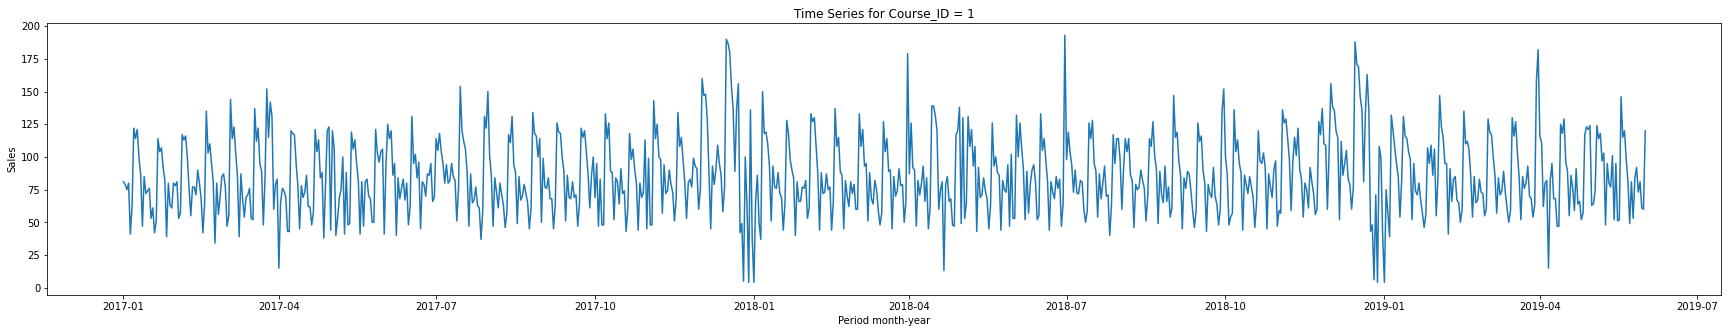

In [12]:
#let's analyse our sales based on the Course_ID = 1
X = train[:882]
X.index = X.timestamp
X = X.drop(['ID', 'timestamp'], axis = 1)
plt.figure(figsize=(30, 5))
plt.plot(X['Sales'], label = 'Sales fot Course_ID = 1')
plt.title('Time Series for Course_ID = 1')
plt.xlabel('Period month-year')
plt.ylabel('Sales')

Text(0, 0.5, 'Sales')

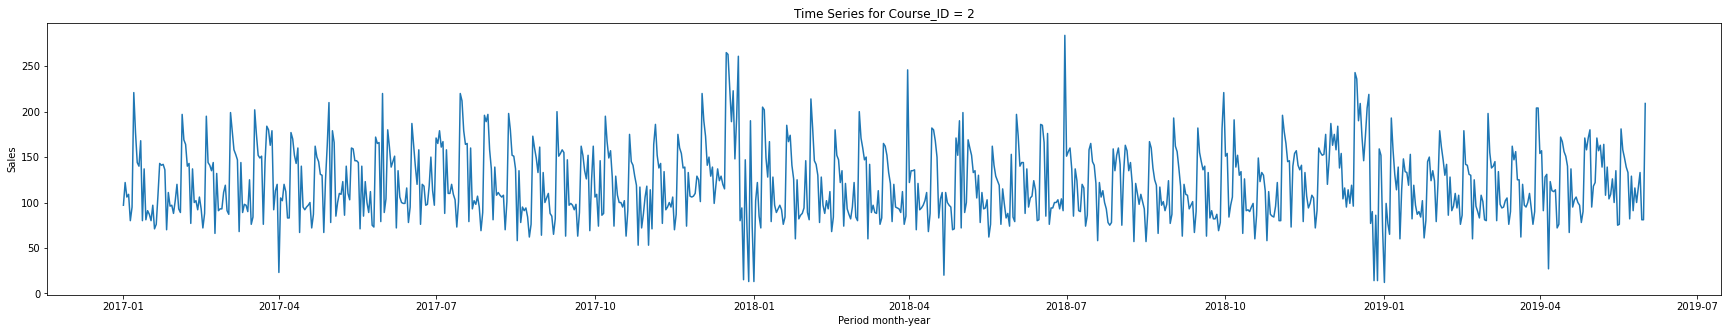

In [13]:
#let's analyse our sales based on the Course_ID = 2
X = train[882:1764]
X.index = X.timestamp
X = X.drop(['ID', 'timestamp'], axis = 1)
plt.figure(figsize=(30, 5))
plt.plot(X['Sales'], label = 'Sales fot Course_ID = 2')
plt.title('Time Series for Course_ID = 2')
plt.xlabel('Period month-year')
plt.ylabel('Sales')

From the graphs we can see the similar patterns for Course_ID = 1 and Course_ID = 2 with peaks in 2017-04, 2018-01, 2018-04, 2019-01, 2019-04. So we won't waste out time checking other IDs as we are expecting the similar picture. Looking at the graph it looks like that out time series is stationary as variance (our spread) is more or less constant over time and our time series is oscilating around the constant mean value. Except two spikes at the end of year 2017 and 2018 but we can leave it as it is.  Let's look at the trend and seasonality using statsmodels library. 

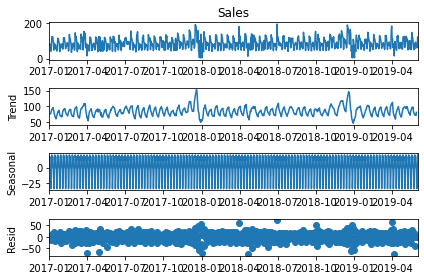

In [14]:
#using classical econometric aproach to check the trend and seasonality
#perform the Dickey-Fuller test using statsmodel library
X = train[:882]
X.index = X.timestamp
X = X['Sales']
import statsmodels.api as sm 
sm.tsa.seasonal_decompose(X).plot() 
result = sm.tsa.stattools.adfuller(X) 
plt.show()

And yes, there is no increasing or decreasing trend in our time series. It means that we can try using the classical econometric approach for our time series e.g. Holt-Winter's method or ARIMA. 

<h3> Use Holt-Winter's method to predict the future sales

In [15]:
X = train[:882]
X.index = X.timestamp

In [16]:
#split for training and validation for Course_ID = 1
X_train, X_valid = train_test_split(X, test_size = 0.2, shuffle = False)

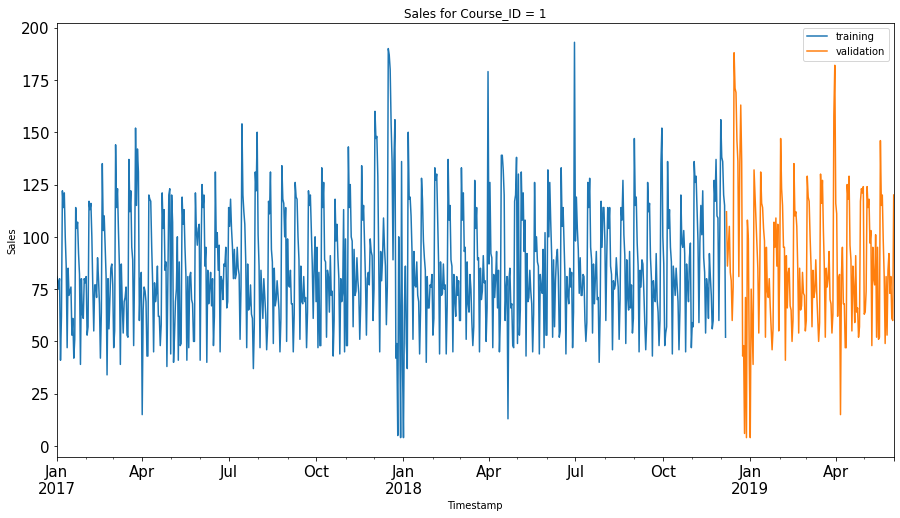

In [17]:
X_train['Sales'].plot(figsize = (15,8), title = 'Sales for Course_ID = 1', fontsize = 15, label = 'training') 
X_valid['Sales'].plot(figsize = (15,8), title = 'Sales for Course_ID = 1', fontsize = 15, label = 'validation') 
plt.xlabel("Timestamp") 
plt.ylabel("Sales") 
plt.legend(loc = 'best') 
plt.show()

In [18]:
from sklearn.metrics import mean_squared_log_error


def rmsle(y, y_pred):
    y_pred = [10 if x < 0 else x for x in y_pred]
    return 1000 * np.sqrt(mean_squared_log_error(y, y_pred))

Below the Holt Winter's method is performed using exponential smoothing for validation set. Seasonal period is set to be 14 as we have a clear pattern that repeats every 2 weeks.  

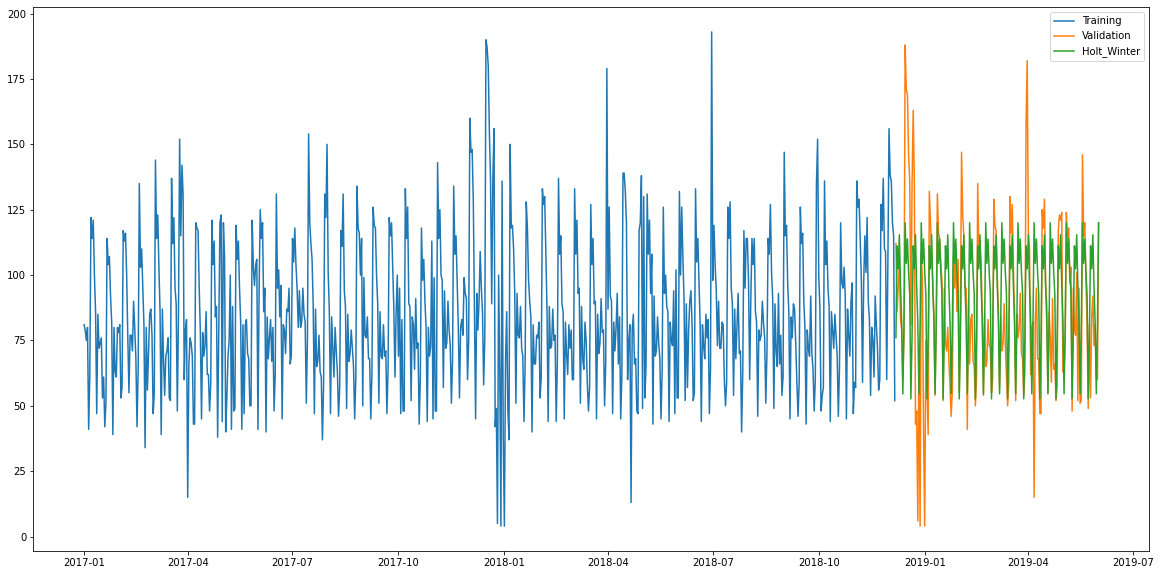

In [19]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

preds = X_valid.copy() 
exp_smoothing = ExponentialSmoothing(np.asarray(X_train['Sales']), seasonal_periods = 14, seasonal = 'add').fit() 
preds['Holt_Winter'] = exp_smoothing.forecast(len(X_valid)) 
plt.figure(figsize = (20, 10)) 
plt.plot(X_train['Sales'], label = 'Training') 
plt.plot(X_valid['Sales'], label = 'Validation') 
plt.plot(preds['Holt_Winter'], label = 'Holt_Winter') 
plt.legend(loc = 'best') 
plt.show()

Let's check the error from using the Holt Winter's method. 

In [20]:
rmsle(X_valid.Sales, preds.Holt_Winter)

479.58949618999833

The error is very high so it is not the best model to use. If we  have a clear trend of time series then this method is quite powerful and can give quite good result. We can try to reduce the error by removing outliers. However, it is not recommended to do so for time series problems as we are loosing very important information in that case. Another method is to "smooth" outliers by taking a log of our target i.e. Sales. 

<h3> ARIMA model 

Let's try classical ARIMA model to predict our Sales. I am not going into details of this method as a lot of papers are written about this approach. I will just show how this method works in out case. In my personal opinion, this method is really complicated because we have to check our time series for stationarity by using Dicky-Fuller test, make its stationar if required by removing trend and seasonality. I do not like this method at all but maybe you can find it is useful. 

In [21]:
import statsmodels.formula.api as smf         
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

def dickey_fuller(y, lags = None, figsize = (10, 5), style = 'bmh'):
    """
        Plot time series, its ACF/autocorrelation and PACF/partial autocorrelation, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize = figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags = lags, ax = acf_ax)
        smt.graphics.plot_pacf(y, lags = lags, ax = pacf_ax)
        plt.tight_layout()

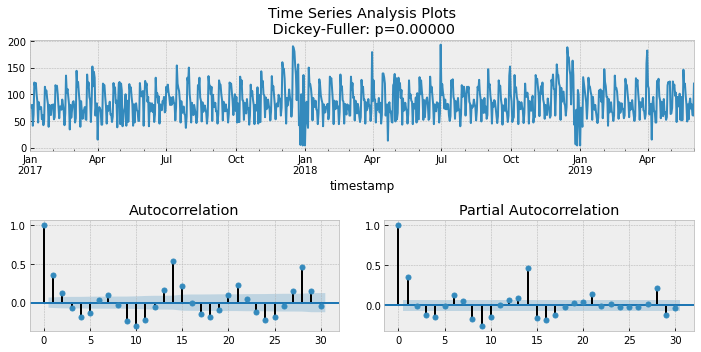

In [23]:
dickey_fuller(X.Sales, lags = 30)

Perfect, our Null hypothesis (our time series is not stationary) is rejected as p_values < 0.05. It is just confirmation of our assumption from the above where we assumed that time series is stationary when we performed Holt Winter's method. 

Now, we have to get rid of seasonality by subtracting the time series from itself but only using the lag that equals to seasonal period which is equal to 14 days in our case. If you go to the graph you can see that the pattern repeats every 2 weeks or 14 days period. 

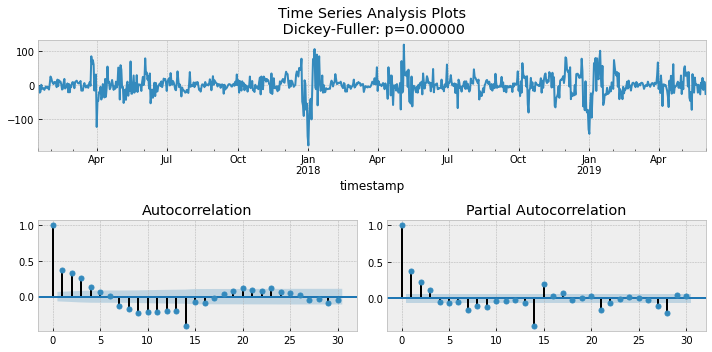

In [25]:
sales_difference = X.Sales - X.Sales.shift(14)
dickey_fuller(sales_difference[14:], lags = 30)

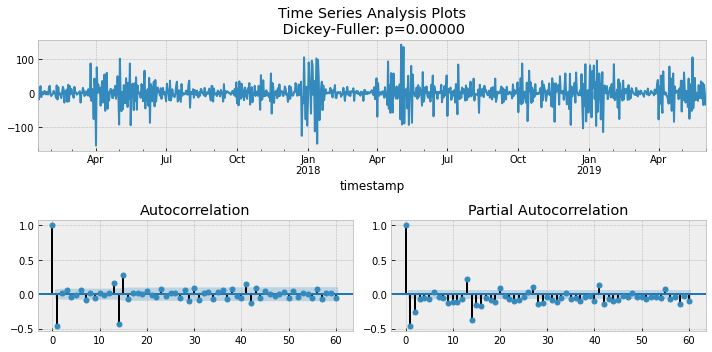

In [26]:
sales_difference = sales_difference - sales_difference.shift(1)
dickey_fuller(sales_difference[14 + 1:], lags = 60)

- 𝑝  is most probably 1 since it is the last significant lag on the PACF, after which, most others are not significant.
- 𝑑  equals 1 because we had first differences
- 𝑞  should be somewhere around 1 as well as seen on the ACF
- 𝑃  might be 2, since 1-st and 14-th lags are somewhat significant on the PACF
- 𝐷  again equals 1 because we performed seasonal differentiation
- 𝑄  is probably 2. The 1-st and 14-th lag on ACF are significant.

In [27]:
from itertools import product 
# setting initial values and some bounds for them
ps = range(1, 3)
d = 1 
qs = range(1, 3)
Ps = range(0, 2)
D = 1 
Qs = range(0, 2)
s = 14 # season length is still 14

# creating list with all the possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

16

In [28]:
from tqdm import tqdm_notebook

def optimizeSARIMA(parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order in ARIMA model
        D - seasonal integration order 
        s - length of season
    """
    
    results = []
    best_aic = float("inf")

    for param in tqdm_notebook(parameters_list):
        # we need try-except because on some combinations model fails to converge
        try:
            model = sm.tsa.statespace.SARIMAX(X.Sales, order = (param[0], d, param[1]), 
                                            seasonal_order = (param[2], D, param[3], s)).fit(disp = -1)
        except:
            continue
        aic = model.aic
        # saving best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    # sorting in ascending order, the lower AIC is - the better
    result_table = result_table.sort_values(by = 'aic', ascending = True).reset_index(drop = True)
    
    return result_table


In [29]:
%%time
result_table = optimizeSARIMA(parameters_list, d, D, s)

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


No frequency information was provided, so inferred frequency D will be used.
No frequency information was provided, so inferred frequency D will be used.
No frequency information was provided, so inferred frequency D will be used.
No frequency information was provided, so inferred frequency D will be used.
No frequency information was provided, so inferred frequency D will be used.
No frequency information was provided, so inferred frequency D will be used.
No frequency information was provided, so inferred frequency D will be used.
No frequency information was provided, so inferred frequency D will be used.
No frequency information was provided, so inferred frequency D will be used.
No frequency information was provided, so inferred frequency D will be used.
No frequency information was provided, so inferred frequency D will be used.
No frequency information was provided, so inferred frequency D will be used.
No frequency information was provided, so inferred frequency D will be used.


CPU times: user 1min 4s, sys: 749 ms, total: 1min 4s
Wall time: 58.5 s


In [30]:
result_table

,parameters,aic
0,"(2, 1, 1, 1)",7766.950994
1,"(1, 1, 1, 1)",7860.322794
2,"(1, 2, 1, 1)",7862.282214
3,"(2, 2, 1, 1)",7863.485196
4,"(2, 1, 1, 0)",7914.589050
5,"(1, 1, 0, 1)",7924.020288
6,"(2, 1, 0, 1)",7925.378335
7,"(1, 2, 0, 1)",7925.977386
8,"(2, 2, 0, 1)",7926.583816
9,"(1, 1, 1, 0)",7949.130500


In [31]:
# set the parameters that give the lowest AIC
p, q, P, Q = result_table.parameters[0]

best_model=sm.tsa.statespace.SARIMAX(X.Sales, order = (p, d, q), 
                                        seasonal_order = (P, D, Q, s)).fit(disp = -1)
print(best_model.summary())

No frequency information was provided, so inferred frequency D will be used.
No frequency information was provided, so inferred frequency D will be used.


                                     SARIMAX Results                                      
Dep. Variable:                              Sales   No. Observations:                  882
Model:             SARIMAX(2, 1, 1)x(1, 1, 1, 14)   Log Likelihood               -3877.475
Date:                            Mon, 06 Jul 2020   AIC                           7766.951
Time:                                    10:02:27   BIC                           7795.541
Sample:                                01-01-2017   HQIC                          7777.892
                                     - 06-01-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2984      0.022     13.407      0.000       0.255       0.342
ar.L2          0.2109      0.027   

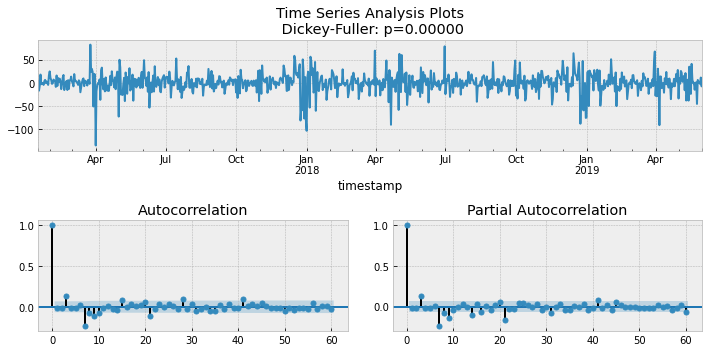

In [32]:
dickey_fuller(best_model.resid[14 + 1:], lags = 60)

In [33]:
X = X['Sales']

In [34]:
X = pd.DataFrame(X)

In [35]:
def plotSARIMA(series, model, n_steps):
    """
        Plots model vs predicted values
        
        series - dataset with timeseries
        model - fitted SARIMA model
        n_steps - number of steps to predict in the future
        
    """
    # adding model values
    data = series.copy()
    data.columns = ['actual']
    data['arima_model'] = model.fittedvalues
    # making a shift on s+d steps, because these values were unobserved by the model
    # due to the differentiating
    data['arima_model'][:s + d] = np.NaN
    
    # forecasting on n_steps forward 
    forecast = model.predict(start = data.shape[0], end = data.shape[0] + n_steps)
    forecast = data.arima_model.append(forecast)
    # calculate error, again having shifted on s+d steps from the beginning
    error = rmsle(data['actual'][s + d:], data['arima_model'][s + d:])

    plt.figure(figsize = (15, 7))
    plt.title("RMSLE Error: {0:.2f}".format(error))
    plt.plot(forecast, color = 'r', label = "model")
    plt.axvspan(data.index[-1], forecast.index[-1], alpha = 0.5, color = 'lightgrey')
    plt.plot(data.actual, label = "actual")
    plt.legend()
    plt.grid(True);


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


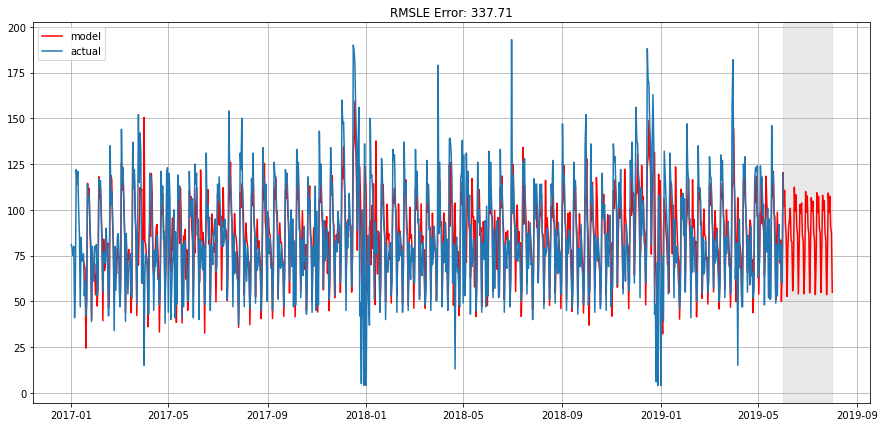

In [36]:
plotSARIMA(X, best_model, 60)

<h3> My approach to solve Time Series problems 

I do prefer to use more robust and less time consuming methods such as linear regression or gradient boosting algorithms to solve classical regression problems as in our case. As we have some features in this task so we can find their application and even do feature engineering to improve the score/reduce the error. 

First of all let's parse some features from the timestamp.

In [38]:
#parsing timestamp as new features
for i in [train, test]:
    i['month'] = i['timestamp'].dt.month
    i['day'] = i['timestamp'].dt.day
    i['dayofweek_num'] = i['timestamp'].dt.dayofweek
    i['dayofweek_name'] = i['timestamp'].dt.day_name()
    i['quarter'] = i['timestamp'].dt.quarter
    i['week_of_year'] = i['timestamp'].dt.weekofyear

# mapping 1 if the day is a weekend else 0
def weekend(x):
    if x.dayofweek == 5 or x.dayofweek == 6:
        return 1
    else:
        return 0 

train['weekend'] = train['timestamp'].apply(weekend) 
test['weekend'] = test['timestamp'].apply(weekend) 

Let's do Label encoding for catgorical features. 

In [39]:
#encoding categorical features
le = LabelEncoder()

for col in ['Course_Domain', 'Course_Type', 'dayofweek_name']:
    train[col] = le.fit_transform(train[col])
    test[col] = le.transform(test[col])

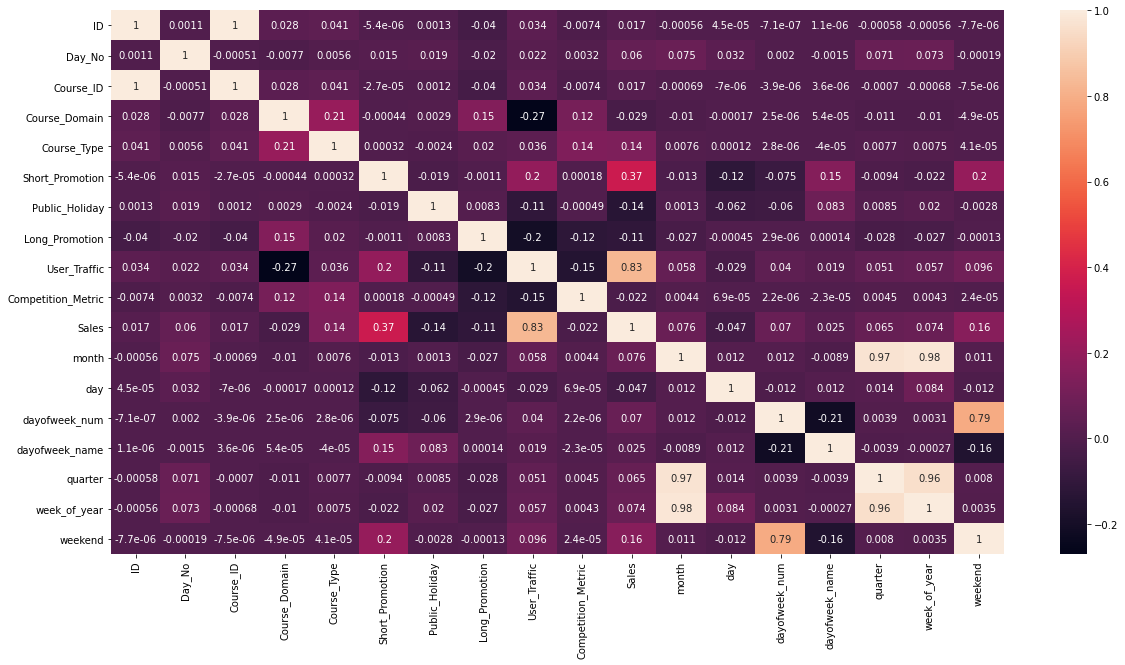

In [42]:
plt.figure(figsize = (20, 10))
sns.heatmap(train.corr(), annot = True)

Looking at the correlation, we can see that Short and Long promotion are correlated with our target variable so we can create the new features based on this independent variables.

The first one is to combine Long and Short promotions as it should have a noticable effect on our sales. If the short and long promotion happen at the same time map 1 else 0.

The second one is to combine promotions and public holidays. See below.

By the way, these two features is pumped my score up from 187 to 139 without using any lags or rolling windows. As simple as that.


In [43]:
def promotions(df):
    if df['Long_Promotion'] == df['Short_Promotion']:
        return 1
    else:
        return 0
    
train['Promotions_match'] = train.apply(promotions, axis = 1)
test['Promotions_match'] = test.apply(promotions, axis = 1)

In [44]:
def promotions_and_holidays(df):
    if df['Long_Promotion'] == df['Public_Holiday'] == 1:
        return 1
    elif df['Short_Promotion'] == df['Public_Holiday'] == 1: 
        return 1
    elif df['Long_Promotion'] == df['Short_Promotion'] == df['Public_Holiday']:
        return 2
    else:
        return 0
    
train['Promotions_and_Holidays'] = train.apply(promotions_and_holidays, axis = 1)
test['Promotions_and_Holidays'] = test.apply(promotions_and_holidays, axis = 1)

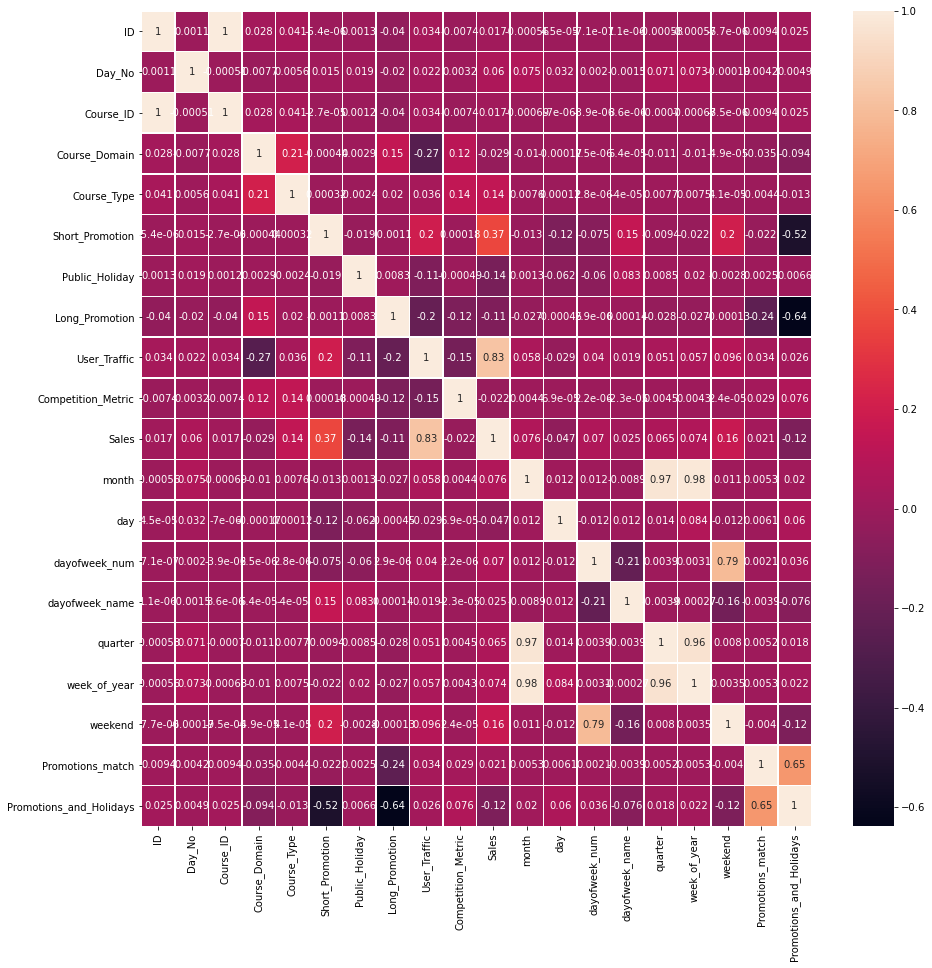

In [45]:
fig, ax = plt.subplots(figsize = (15,15))      
sns.heatmap(train.corr(), annot = True, linewidths = .5, ax = ax)

In [46]:
train.index = train['timestamp']
test.index = test['timestamp']

train = train.drop('timestamp', axis = 1)
test = test.drop('timestamp', axis = 1)

<h3> Target encoding

In [48]:
def target_encoding(data, feature, target):
    """
    Returns a dictionary where keys are unique categories of the cat_feature,
    and values are means over real_feature
    """
    return dict(data.groupby(feature)[target].mean())

In [49]:
train['day_encoded'] = list(map(target_encoding(train, 'day', 'Sales').get, train.day))
train['month_encoded'] = list(map(target_encoding(train, 'month', 'Sales').get, train.month))

test['day_encoded'] = list(map(target_encoding(train, 'day', 'Sales').get, test.day))
test['month_encoded'] = list(map(target_encoding(train, 'month', 'Sales').get, test.month))

train['day_encoded_traffic'] = list(map(target_encoding(train, 'day', 'User_Traffic').get, train.day))
train['month_encoded_traffic'] = list(map(target_encoding(train, 'month', 'User_Traffic').get, train.month))

test['day_encoded_traffic'] = list(map(target_encoding(train, 'day', 'User_Traffic').get, test.day))
test['month_encoded_traffic'] = list(map(target_encoding(train, 'month', 'User_Traffic').get, test.month))

train.drop(['day', 'month'], axis=1, inplace=True)
test.drop(['day', 'month'], axis=1, inplace=True)

In [50]:
train.head()

,ID,Day_No,Course_ID,Course_Domain,Course_Type,Short_Promotion,Public_Holiday,Long_Promotion,User_Traffic,Competition_Metric,...,dayofweek_name,quarter,week_of_year,weekend,Promotions_match,Promotions_and_Holidays,day_encoded,month_encoded,day_encoded_traffic,month_encoded_traffic
timestamp,,,,,,,,,,,,,,,,,,,,,
2017-01-01,1,1,1,1,0,0,1,1,11004,0.007,...,3,1,52,1,0,1,118.655180,112.676804,14736.144659,14368.417982
2017-01-02,2,2,1,1,0,0,0,1,13650,0.007,...,1,1,1,0,0,0,137.200333,112.676804,16949.243142,14368.417982
2017-01-03,3,3,1,1,0,0,0,1,11655,0.007,...,5,1,1,0,0,0,129.351146,112.676804,15993.147132,14368.417982
2017-01-04,4,4,1,1,0,0,0,1,12054,0.007,...,6,1,1,0,0,0,137.100641,112.676804,16693.083541,14368.417982
2017-01-05,5,5,1,1,0,0,0,1,6804,0.007,...,4,1,1,0,0,0,131.901556,112.676804,16184.503741,14368.417982


In [51]:
test.head()

,ID,Day_No,Course_ID,Course_Domain,Course_Type,Short_Promotion,Public_Holiday,Long_Promotion,Competition_Metric,dayofweek_num,dayofweek_name,quarter,week_of_year,weekend,Promotions_match,Promotions_and_Holidays,day_encoded,month_encoded,day_encoded_traffic,month_encoded_traffic
timestamp,,,,,,,,,,,,,,,,,,,,
2019-06-02,883,883,1,1,0,1,0,1,0.007,6,3,2,22,1,1,0,137.200333,120.439262,16949.243142,15346.746066
2019-06-03,884,884,1,1,0,1,0,1,0.007,0,1,2,23,0,1,0,129.351146,120.439262,15993.147132,15346.746066
2019-06-04,885,885,1,1,0,1,0,1,0.007,1,5,2,23,0,1,0,137.100641,120.439262,16693.083541,15346.746066
2019-06-05,886,886,1,1,0,1,0,1,0.007,2,6,2,23,0,1,0,131.901556,120.439262,16184.503741,15346.746066
2019-06-06,887,887,1,1,0,0,0,1,0.007,3,4,2,23,0,0,0,121.246052,120.439262,15288.423940,15346.746066


<h3> Create lag features

Let's create lag features for our time series. It should improve our score a lot as our future values depend on the past values due to the seasonal pattern of the graph. In this case, we have to experiment with the value of the lag and try different ones by using ACF and PACF plots. 

In [52]:
X = train.loc[train['Course_ID'] == 1]
# Creating a copy of the initial datagrame to make various transformations 
data = pd.DataFrame(X.copy())

# lags= [60,61,68,75,82,89,90,91,98,105,112,119,126,182,364,365,366,546]
lags = [60, 61, 74]

# Adding the lag of the target variable from 1 steps back up to 60
for i in lags:
    data["sales_lag_{}".format(i)] = data.Sales.shift(i)
#     data["traffic_lag_{}".format(i)] = data.User_Traffic.shift(i)
   

<h3> Training and Validation

In [59]:
y = data['Sales'].fillna(int(-999))
X = data.drop(['ID', 'Sales', 'Day_No', 'Course_ID'], axis = 1).fillna(int(-999))

# reserve 20% of data for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = False)

Let's check p-values and coefficients of the features created just simply using OLS.

In [60]:
if 'const' not in X.columns:
    X = sm.add_constant(X)
    
model = sm.OLS(y, X)
results = model.fit()

print('R2: ', round(results.rsquared, 3))
print('R2 adj: ', round(results.rsquared_adj, 3))
print('gap between R2 and adj R2: ', round(results.rsquared - results.rsquared_adj, 3)) 
print('\n')

print(results.summary())

R2:  0.913
R2 adj:  0.911
gap between R2 and adj R2:  0.002


                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.913
Model:                            OLS   Adj. R-squared:                  0.911
Method:                 Least Squares   F-statistic:                     602.5
Date:                Mon, 06 Jul 2020   Prob (F-statistic):               0.00
Time:                        10:28:22   Log-Likelihood:                -3159.8
No. Observations:                 882   AIC:                             6352.
Df Residuals:                     866   BIC:                             6428.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------

In [63]:
from sklearn.metrics import mean_squared_log_error

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

def mape(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def rmsle(y, y_pred):
    y_pred = [10 if x < 0 else x for x in y_pred]
    return 1000 * np.sqrt(mean_squared_log_error(y, y_pred))


RMSLE = make_scorer(rmsle, greater_is_better = False)
MAPE = make_scorer(mape, greater_is_better = False)
            
model = Lasso()

tscv = TimeSeriesSplit(n_splits=10)

scores = cross_val_score(model, X, y, scoring = RMSLE, cv = tscv)
print(f'Cross-validation scores: {scores}')

print(scores.mean())

Cross-validation scores: [-138.55103039 -137.98967442  -79.36483701 -175.12056809  -81.95059445
 -146.96560139  -73.0036231   -88.30079713 -196.65745025  -90.61977483]
-120.8523951042426


So it is clear that we easily beaten SARIMA model. RMSLE = 120.85 for Lasso Regression against RMSLE = 337.71 for SARIMA. Huge difference. To further improve the score it is worth to try Gradient Boosting algorithms such as catboost, lgbm or xgboost.